# Phase 2: Feature Engineering

This notebook creates features for the Rossmann forecasting models.

**Objectives:**
- Load cleaned data from Phase 1
- Create calendar features (year, month, week, seasonality)
- Create promotion features (Promo2 active, duration)
- Create competition features (distance log-scaled, age)
- Create lag features (1, 7, 14, 28 days) with proper groupby.shift()
- Create rolling features (means, stds) with proper groupby.rolling()
- Save featured data to `data/processed/train_features.parquet`

**CRITICAL:** All lag and rolling features use `groupby("Store")` to prevent data leakage across stores.

## Setup

In [1]:
import sys
from pathlib import Path

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

from features.build_features import (
    add_calendar_features,
    add_promo_features,
    add_competition_features,
    add_lag_features,
    add_rolling_features,
    build_all_features
)
from utils.io import read_parquet, save_parquet

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Setup complete!")

Setup complete!


## 1. Load Cleaned Data

In [2]:
# Load cleaned data from Phase 1
df = read_parquet('../data/processed/train_clean.parquet')

print(f"Loaded data shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Number of stores: {df['Store'].nunique()}")
print(f"\nColumns: {list(df.columns)}")

Loaded data shape: (1017209, 18)
Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00
Number of stores: 1115

Columns: ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']


## 2. Load Configuration

In [3]:
# Load feature engineering config from params.yaml
with open('../config/params.yaml', 'r') as f:
    params = yaml.safe_load(f)

feature_config = params['features']

print("Feature Engineering Configuration:")
print(f"  Lags: {feature_config['lags']}")
print(f"  Rolling windows: {feature_config['rolling_windows']}")
print(f"  Include promo features: {feature_config['include_promo_features']}")
print(f"  Include competition features: {feature_config['include_competition_features']}")

Feature Engineering Configuration:
  Lags: [1, 7, 14, 28]
  Rolling windows: [7, 14, 28, 60]
  Include promo features: True
  Include competition features: True


## 3. Calendar Features

Extract temporal patterns from the Date column.

In [4]:
# Add calendar features
df_cal = add_calendar_features(df)

# Show new calendar features
calendar_cols = ['Year', 'Month', 'Week', 'Day', 'Quarter', 'Season',
                 'IsMonthStart', 'IsMonthEnd', 'IsWeekend']

print("Sample of calendar features:")
display(df_cal[['Date'] + calendar_cols].head(10))

print("\nCalendar feature summary:")
display(df_cal[calendar_cols].describe())

2025-11-30 22:19:47 - features.build_features - INFO - Adding calendar features
2025-11-30 22:19:47 - features.build_features - INFO - Added 11 calendar features
Sample of calendar features:


,Date,Year,Month,Week,Day,Quarter,Season,IsMonthStart,IsMonthEnd,IsWeekend
0,2013-01-01,2013,1,1,1,1,0,1,0,0
1,2013-01-02,2013,1,1,2,1,0,0,0,0
2,2013-01-03,2013,1,1,3,1,0,0,0,0
3,2013-01-04,2013,1,1,4,1,0,0,0,0
4,2013-01-05,2013,1,1,5,1,0,0,0,1
5,2013-01-06,2013,1,1,6,1,0,0,0,1
6,2013-01-07,2013,1,2,7,1,0,0,0,0
7,2013-01-08,2013,1,2,8,1,0,0,0,0
8,2013-01-09,2013,1,2,9,1,0,0,0,0
9,2013-01-10,2013,1,2,10,1,0,0,0,0



Calendar feature summary:


,Year,Month,Week,Day,Quarter,Season,IsMonthStart,IsMonthEnd,IsWeekend
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,2.013832e+03,5.846762e+00,2.361551e+01,1.570279e+01,2.294252e+00,1.367880e+00,3.291752e-02,3.291851e-02,2.845630e-01
std,7.773960e-01,3.326097e+00,1.443338e+01,8.787638e+00,1.081850e+00,1.054663e+00,1.784208e-01,1.784234e-01,4.512063e-01
min,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.013000e+03,3.000000e+00,1.100000e+01,8.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.014000e+03,6.000000e+00,2.200000e+01,1.600000e+01,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.014000e+03,8.000000e+00,3.500000e+01,2.300000e+01,3.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,2.015000e+03,1.200000e+01,5.200000e+01,3.100000e+01,4.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## 4. Promotion Features

Create features related to Promo and Promo2 campaigns.

In [5]:
# Add promotion features
df_promo = add_promo_features(df_cal)

# Show new promo features
promo_cols = ['Promo', 'Promo2', 'Promo2Active', 'Promo2Duration',
              'PromoInterval_JAJO', 'PromoInterval_FMAN', 'PromoInterval_MJSD']

print("Sample of promotion features:")
display(df_promo[['Date', 'Store'] + promo_cols].head(10))

print("\nPromo2Active distribution:")
print(df_promo['Promo2Active'].value_counts())

print("\nPromoInterval patterns:")
for col in ['PromoInterval_JAJO', 'PromoInterval_FMAN', 'PromoInterval_MJSD']:
    print(f"{col}: {df_promo[col].sum():,} stores")

2025-11-30 22:19:47 - features.build_features - INFO - Adding promotion features
2025-11-30 22:20:05 - features.build_features - INFO - Added 5 promotion features
Sample of promotion features:


,Date,Store,Promo,Promo2,Promo2Active,Promo2Duration,PromoInterval_JAJO,PromoInterval_FMAN,PromoInterval_MJSD
0,2013-01-01,1,0,0,0,0,0,0,0
1,2013-01-02,1,0,0,0,0,0,0,0
2,2013-01-03,1,0,0,0,0,0,0,0
3,2013-01-04,1,0,0,0,0,0,0,0
4,2013-01-05,1,0,0,0,0,0,0,0
5,2013-01-06,1,0,0,0,0,0,0,0
6,2013-01-07,1,1,0,0,0,0,0,0
7,2013-01-08,1,1,0,0,0,0,0,0
8,2013-01-09,1,1,0,0,0,0,0,0
9,2013-01-10,1,1,0,0,0,0,0,0



Promo2Active distribution:
Promo2Active
0    842417
1    174792
Name: count, dtype: int64

PromoInterval patterns:
PromoInterval_JAJO: 293,122 stores
PromoInterval_FMAN: 118,596 stores
PromoInterval_MJSD: 97,460 stores


## 5. Competition Features

Create features related to nearby competition.

In [6]:
# Add competition features
df_comp = add_competition_features(df_promo)

# Show new competition features
comp_cols = ['CompetitionDistance', 'CompetitionDistance_log',
             'HasCompetition', 'CompetitionAge']

print("Sample of competition features:")
display(df_comp[['Date', 'Store'] + comp_cols].head(10))

print("\nCompetition feature summary:")
display(df_comp[comp_cols].describe())

print(f"\nStores with competition: {df_comp['HasCompetition'].sum() / len(df_comp) * 100:.2f}%")

2025-11-30 22:20:05 - features.build_features - INFO - Adding competition features
2025-11-30 22:21:01 - features.build_features - INFO - Added 3 competition features
Sample of competition features:


,Date,Store,CompetitionDistance,CompetitionDistance_log,HasCompetition,CompetitionAge
0,2013-01-01,1,1270.0,7.147559,1,1583
1,2013-01-02,1,1270.0,7.147559,1,1584
2,2013-01-03,1,1270.0,7.147559,1,1585
3,2013-01-04,1,1270.0,7.147559,1,1586
4,2013-01-05,1,1270.0,7.147559,1,1587
5,2013-01-06,1,1270.0,7.147559,1,1588
6,2013-01-07,1,1270.0,7.147559,1,1589
7,2013-01-08,1,1270.0,7.147559,1,1590
8,2013-01-09,1,1270.0,7.147559,1,1591
9,2013-01-10,1,1270.0,7.147559,1,1592



Competition feature summary:


,CompetitionDistance,CompetitionDistance_log,HasCompetition,CompetitionAge
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.675712e+03,7.653923e+00,9.974027e-01,1.288311e+03
std,9.085164e+03,1.568901e+00,5.089754e-02,1.992694e+03
min,2.000000e+01,3.044523e+00,0.000000e+00,0.000000e+00
25%,7.100000e+02,6.566672e+00,1.000000e+00,0.000000e+00
50%,2.330000e+03,7.754053e+00,1.000000e+00,5.100000e+02
75%,6.910000e+03,8.840870e+00,1.000000e+00,2.234000e+03
max,1.000000e+05,1.151294e+01,1.000000e+00,4.221400e+04



Stores with competition: 99.74%


## 6. Lag Features

Create store-level lag features using `groupby("Store").shift(lag)`.

**CRITICAL:** This prevents data leakage across stores.

In [7]:
# Add lag features
lags = feature_config['lags']
df_lag = add_lag_features(df_comp, lags=lags)

# Show lag features for one store
sample_store = 1
lag_cols = [f'Sales_Lag_{lag}' for lag in lags]

print(f"Sample lag features for Store {sample_store}:")
display(df_lag[df_lag['Store'] == sample_store][['Date', 'Sales'] + lag_cols].head(30))

print("\nLag feature missing value counts (expected for early dates):")
for col in lag_cols:
    missing = df_lag[col].isna().sum()
    print(f"{col}: {missing:,} ({missing/len(df_lag)*100:.2f}%)")

2025-11-30 22:21:01 - features.build_features - INFO - Adding lag features for Sales with lags: [1, 7, 14, 28]
2025-11-30 22:21:01 - features.build_features - INFO -   Created Sales_Lag_1
2025-11-30 22:21:01 - features.build_features - INFO -   Created Sales_Lag_7
2025-11-30 22:21:01 - features.build_features - INFO -   Created Sales_Lag_14
2025-11-30 22:21:01 - features.build_features - INFO -   Created Sales_Lag_28
2025-11-30 22:21:01 - features.build_features - INFO - Added 4 lag features
Sample lag features for Store 1:


,Date,Sales,Sales_Lag_1,Sales_Lag_7,Sales_Lag_14,Sales_Lag_28
0,2013-01-01,0.0,NaN,NaN,NaN,NaN
1,2013-01-02,5530.0,0.0,NaN,NaN,NaN
2,2013-01-03,4327.0,5530.0,NaN,NaN,NaN
3,2013-01-04,4486.0,4327.0,NaN,NaN,NaN
4,2013-01-05,4997.0,4486.0,NaN,NaN,NaN
5,2013-01-06,0.0,4997.0,NaN,NaN,NaN
6,2013-01-07,7176.0,0.0,NaN,NaN,NaN
7,2013-01-08,5580.0,7176.0,0.0,NaN,NaN
8,2013-01-09,5471.0,5580.0,5530.0,NaN,NaN
9,2013-01-10,4892.0,5471.0,4327.0,NaN,NaN



Lag feature missing value counts (expected for early dates):
Sales_Lag_1: 1,115 (0.11%)
Sales_Lag_7: 7,805 (0.77%)
Sales_Lag_14: 15,610 (1.53%)
Sales_Lag_28: 31,220 (3.07%)


## 7. Rolling Window Features

Create store-level rolling statistics using `groupby("Store").rolling(window)`.

**CRITICAL:** This prevents data leakage across stores.

In [8]:
# Add rolling features
windows = feature_config['rolling_windows']
df_rolling = add_rolling_features(df_lag, windows=windows)

# Show rolling features for one store
rolling_cols = []
for window in windows:
    rolling_cols.extend([f'Sales_RollingMean_{window}', f'Sales_RollingStd_{window}'])

print(f"Sample rolling features for Store {sample_store}:")
display(df_rolling[df_rolling['Store'] == sample_store][['Date', 'Sales'] + rolling_cols[:4]].head(60))

print("\nRolling feature summary:")
display(df_rolling[rolling_cols].describe())

2025-11-30 22:21:01 - features.build_features - INFO - Adding rolling features for Sales with windows: [7, 14, 28, 60]
2025-11-30 22:21:01 - features.build_features - INFO -   Created Sales_RollingMean_7
2025-11-30 22:21:01 - features.build_features - INFO -   Created Sales_RollingStd_7
2025-11-30 22:21:02 - features.build_features - INFO -   Created Sales_RollingMean_14
2025-11-30 22:21:02 - features.build_features - INFO -   Created Sales_RollingStd_14
2025-11-30 22:21:02 - features.build_features - INFO -   Created Sales_RollingMean_28
2025-11-30 22:21:02 - features.build_features - INFO -   Created Sales_RollingStd_28
2025-11-30 22:21:02 - features.build_features - INFO -   Created Sales_RollingMean_60
2025-11-30 22:21:02 - features.build_features - INFO -   Created Sales_RollingStd_60
2025-11-30 22:21:02 - features.build_features - INFO - Added 8 rolling features
Sample rolling features for Store 1:


,Date,Sales,Sales_RollingMean_7,Sales_RollingStd_7,Sales_RollingMean_14,Sales_RollingStd_14
0,2013-01-01,0.0,0.000000,NaN,0.000000,NaN
1,2013-01-02,5530.0,2765.000000,3910.300537,2765.000000,3910.300537
2,2013-01-03,4327.0,3285.666748,2908.351074,3285.666748,2908.351074
3,2013-01-04,4486.0,3585.750000,2449.327393,3585.750000,2449.327393
4,2013-01-05,4997.0,3868.000000,2213.081299,3868.000000,2213.081299
5,2013-01-06,0.0,3223.333252,2532.144043,3223.333252,2532.144043
6,2013-01-07,7176.0,3788.000000,2752.283936,3788.000000,2752.283936
7,2013-01-08,5580.0,4585.143066,2231.018555,4012.000000,2625.704102
8,2013-01-09,5471.0,4576.714355,2226.961914,4174.111328,2503.807617
9,2013-01-10,4892.0,4657.428711,2226.641602,4245.899902,2371.503174



Rolling feature summary:


,Sales_RollingMean_7,Sales_RollingStd_7,Sales_RollingMean_14,Sales_RollingStd_14,Sales_RollingMean_28,Sales_RollingStd_28,Sales_RollingMean_60,Sales_RollingStd_60
count,1.017209e+06,1.016094e+06,1.017209e+06,1.016094e+06,1.017209e+06,1.016094e+06,1.017209e+06,1.016094e+06
mean,5.756711e+03,3.071843e+03,5.752271e+03,3.089067e+03,5.746129e+03,3.071705e+03,5.732582e+03,3.068039e+03
std,2.321258e+03,1.270197e+03,2.178586e+03,1.170129e+03,2.142026e+03,1.120261e+03,2.116779e+03,1.081589e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.226143e+03,2.208806e+03,4.329929e+03,2.304385e+03,4.346286e+03,2.315243e+03,4.350700e+03,2.333370e+03
50%,5.357429e+03,2.841979e+03,5.398500e+03,2.886707e+03,5.412000e+03,2.886841e+03,5.412383e+03,2.897526e+03
75%,6.771857e+03,3.654715e+03,6.691786e+03,3.626118e+03,6.670036e+03,3.592340e+03,6.647667e+03,3.583512e+03
max,2.938043e+04,1.793011e+04,2.613929e+04,1.793011e+04,2.483718e+04,1.793011e+04,2.296165e+04,1.793011e+04


## 8. Build All Features (Alternative Method)

You can also use the `build_all_features()` orchestration function to create all features at once.

In [9]:
# Alternative: Build all features at once
# (We'll use the step-by-step df_rolling from above, but showing this for reference)

# df_featured = build_all_features(df, config=feature_config)

# For this notebook, we'll use the step-by-step result
df_featured = df_rolling.copy()

print(f"\nFinal featured dataset shape: {df_featured.shape}")
print(f"Total features created: {df_featured.shape[1] - df.shape[1]}")


Final featured dataset shape: (1017209, 50)
Total features created: 32


## 9. Feature Summary

In [10]:
print("="*60)
print("FEATURE ENGINEERING SUMMARY")
print("="*60)
print(f"Original columns: {df.shape[1]}")
print(f"Final columns: {df_featured.shape[1]}")
print(f"Features added: {df_featured.shape[1] - df.shape[1]}")
print(f"\nRows: {len(df_featured):,}")
print(f"Stores: {df_featured['Store'].nunique()}")
print(f"Date range: {df_featured['Date'].min()} to {df_featured['Date'].max()}")

print("\nFeature categories:")
print(f"  Calendar features: 11")
print(f"  Promotion features: 5")
print(f"  Competition features: 3")
print(f"  Lag features: {len(lags)}")
print(f"  Rolling features: {len(windows) * 2}")

print("\nMissing values by feature type:")
lag_missing = df_featured[[f'Sales_Lag_{lag}' for lag in lags]].isna().sum().sum()
rolling_missing = df_featured[rolling_cols].isna().sum().sum()
print(f"  Lag features: {lag_missing:,} ({lag_missing/len(df_featured)/len(lags)*100:.2f}% avg)")
print(f"  Rolling features: {rolling_missing:,} ({rolling_missing/len(df_featured)/len(rolling_cols)*100:.2f}% avg)")
print("="*60)

FEATURE ENGINEERING SUMMARY
Original columns: 18
Final columns: 50
Features added: 32

Rows: 1,017,209
Stores: 1115
Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00

Feature categories:
  Calendar features: 11
  Promotion features: 5
  Competition features: 3
  Lag features: 4
  Rolling features: 8

Missing values by feature type:
  Lag features: 55,750 (1.37% avg)
  Rolling features: 4,460 (0.05% avg)


## 10. Feature Visualization

Visualize some of the new features.

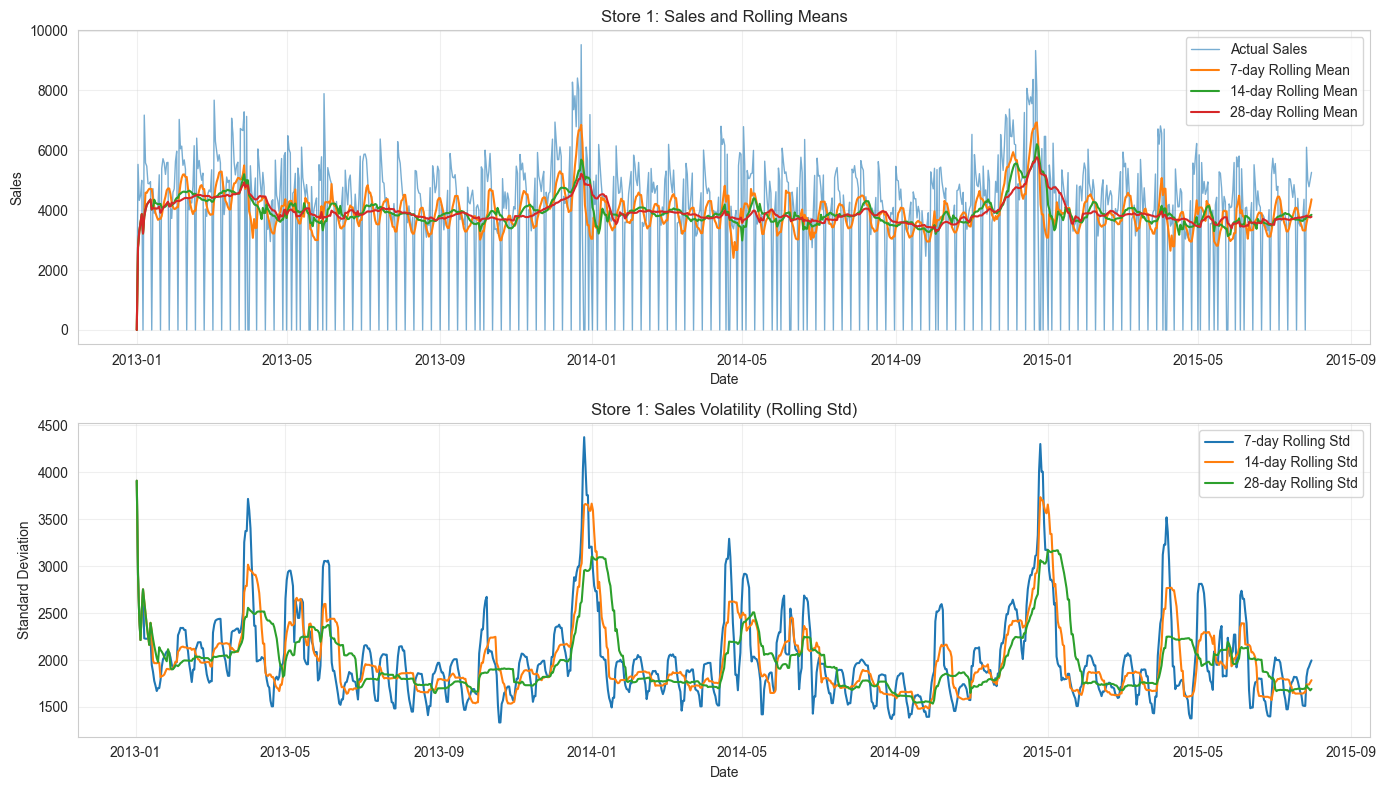

Saved: outputs/figures/08_rolling_features_example.png


In [11]:
# Plot rolling features for a sample store
sample_store_data = df_featured[df_featured['Store'] == sample_store].copy()

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Actual sales vs rolling means
axes[0].plot(sample_store_data['Date'], sample_store_data['Sales'], 
             label='Actual Sales', alpha=0.6, linewidth=1)
for window in [7, 14, 28]:
    axes[0].plot(sample_store_data['Date'], 
                 sample_store_data[f'Sales_RollingMean_{window}'],
                 label=f'{window}-day Rolling Mean', linewidth=1.5)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales')
axes[0].set_title(f'Store {sample_store}: Sales and Rolling Means')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Rolling standard deviations
for window in [7, 14, 28]:
    axes[1].plot(sample_store_data['Date'], 
                 sample_store_data[f'Sales_RollingStd_{window}'],
                 label=f'{window}-day Rolling Std', linewidth=1.5)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Standard Deviation')
axes[1].set_title(f'Store {sample_store}: Sales Volatility (Rolling Std)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/08_rolling_features_example.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: outputs/figures/08_rolling_features_example.png")

Correlation of lag features with Sales:


Sales           1.000000
Sales_Lag_14    0.793680
Sales_Lag_28    0.776142
Sales_Lag_7     0.674894
Sales_Lag_1     0.278360
Name: Sales, dtype: float64

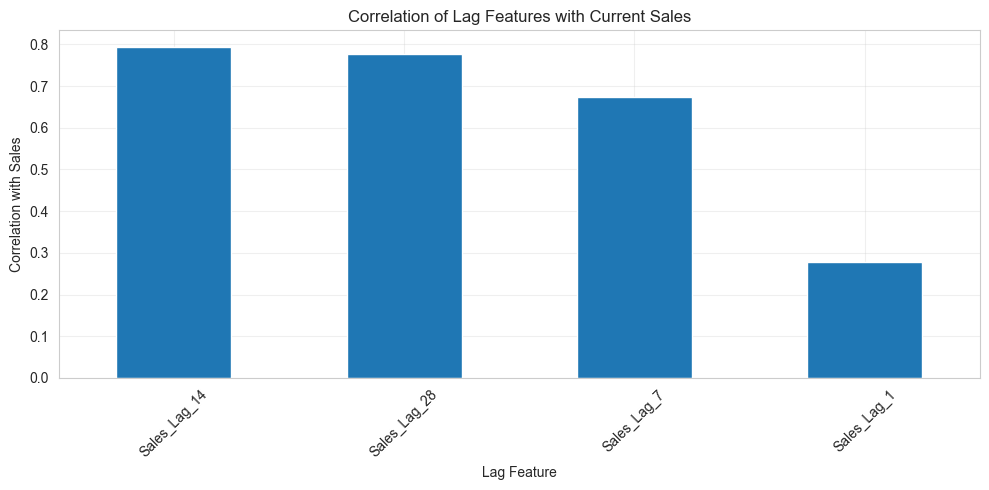

Saved: outputs/figures/09_lag_correlations.png


In [12]:
# Correlation of lag features with Sales
lag_corr = df_featured[['Sales'] + [f'Sales_Lag_{lag}' for lag in lags]].corr()['Sales'].sort_values(ascending=False)

print("Correlation of lag features with Sales:")
display(lag_corr)

# Plot
plt.figure(figsize=(10, 5))
lag_corr[1:].plot(kind='bar')
plt.xlabel('Lag Feature')
plt.ylabel('Correlation with Sales')
plt.title('Correlation of Lag Features with Current Sales')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/09_lag_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: outputs/figures/09_lag_correlations.png")

## 11. Data Quality Check

Verify that lag/rolling features are calculated correctly and don't leak data.

In [13]:
# Verify lag feature correctness for Store 1
store1 = df_featured[df_featured['Store'] == 1].sort_values('Date').head(10)

print("Verification: Sales_Lag_7 should equal Sales from 7 days ago")
print("(First 7 rows will be NaN since there's no data 7 days prior)\n")

display(store1[['Date', 'Sales', 'Sales_Lag_1', 'Sales_Lag_7']])

# Check that there's no leakage across stores
print("\n" + "="*60)
print("Verifying no data leakage across stores...")
print("="*60)

# Get first date for Store 1 and Store 2
store1_first = df_featured[df_featured['Store'] == 1].sort_values('Date').iloc[0]
store2_first = df_featured[df_featured['Store'] == 2].sort_values('Date').iloc[0]

print(f"\nStore 1 first date lag features (should be NaN):")
print(f"  Sales_Lag_1: {store1_first['Sales_Lag_1']}")
print(f"  Sales_Lag_7: {store1_first['Sales_Lag_7']}")

print(f"\nStore 2 first date lag features (should be NaN):")
print(f"  Sales_Lag_1: {store2_first['Sales_Lag_1']}")
print(f"  Sales_Lag_7: {store2_first['Sales_Lag_7']}")

print("\n✓ Verification complete: Lag features are store-specific (no leakage)")

Verification: Sales_Lag_7 should equal Sales from 7 days ago
(First 7 rows will be NaN since there's no data 7 days prior)



,Date,Sales,Sales_Lag_1,Sales_Lag_7
0,2013-01-01,0.0,NaN,NaN
1,2013-01-02,5530.0,0.0,NaN
2,2013-01-03,4327.0,5530.0,NaN
3,2013-01-04,4486.0,4327.0,NaN
4,2013-01-05,4997.0,4486.0,NaN
5,2013-01-06,0.0,4997.0,NaN
6,2013-01-07,7176.0,0.0,NaN
7,2013-01-08,5580.0,7176.0,0.0
8,2013-01-09,5471.0,5580.0,5530.0
9,2013-01-10,4892.0,5471.0,4327.0



Verifying no data leakage across stores...

Store 1 first date lag features (should be NaN):
  Sales_Lag_1: nan
  Sales_Lag_7: nan

Store 2 first date lag features (should be NaN):
  Sales_Lag_1: nan
  Sales_Lag_7: nan

✓ Verification complete: Lag features are store-specific (no leakage)


## 12. Save Featured Data

In [14]:
# Save featured data to parquet
output_path = '../data/processed/train_features.parquet'
save_parquet(df_featured, output_path)

# Report file size
file_size_mb = Path(output_path).stat().st_size / (1024 * 1024)

print("\n" + "="*60)
print("Phase 2 Complete!")
print("="*60)
print(f"Featured data saved to: {output_path}")
print(f"File size: {file_size_mb:.2f} MB")
print(f"Rows: {len(df_featured):,}")
print(f"Columns: {len(df_featured.columns)}")
print(f"Features added: {len(df_featured.columns) - len(df.columns)}")
print(f"\nReady for Phase 3: Baseline Models & Time-Series CV")
print("="*60)


Phase 2 Complete!
Featured data saved to: ../data/processed/train_features.parquet
File size: 42.34 MB
Rows: 1,017,209
Columns: 50
Features added: 32

Ready for Phase 3: Baseline Models & Time-Series CV
